# TensorRT Inferencing with ONNX Conversion

In this example, we see the following TensorRT workflow with ONNX conversion.

1. First we see TensorFlow inferencing for image classification with ResNet50.
2. Next we convert TensorFlow model into ONNX.
3. Generate TensorRT engine from ONNX model and serialize this engine.
4. Load this engine and run inferencing.

## 1. Transform Sample Images

### Show original sample images

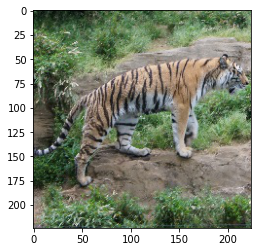

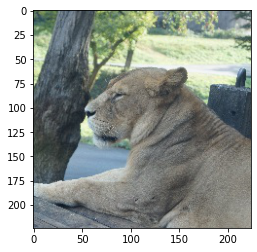

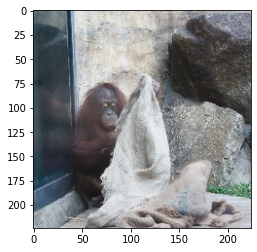

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

img = mpimg.imread('./tiger224x224.jpg')
plt.imshow(np.array(img))
plt.show()

img = mpimg.imread('./lion224x224.jpg')
plt.imshow(np.array(img))
plt.show()

img = mpimg.imread('./orangutan224x224.jpg')
plt.imshow(np.array(img))
plt.show()

### Transform these images into BGR for VGG preprocessing

In [2]:
import tensorflow as tf

#
# Create transformation graph
#
in_images = tf.placeholder(tf.string, name='in_images')
decoded_input = tf.image.decode_jpeg(in_images, channels=3)
float_input = tf.cast(decoded_input, dtype=tf.float32)
# (224, 224, 3) -> (n, 224, 224, 3)
rgb_input = tf.expand_dims(
    float_input,
    axis=0)
# For VGG preprocess, reduce means and convert to BGR
slice_red = tf.slice(
    rgb_input,
    [0, 0, 0, 0],
    [1, 224, 224, 1])
slice_green = tf.slice(
    rgb_input,
    [0, 0, 0, 1],
    [1, 224, 224, 1])
slice_blue = tf.slice(
    rgb_input,
    [0, 0, 0, 2],
    [1, 224, 224, 1])
sub_red = tf.subtract(slice_red, 123.68)
sub_green = tf.subtract(slice_green, 116.779)
sub_blue = tf.subtract(slice_blue, 103.939)
transferred_input = tf.concat(
    [sub_blue, sub_green, sub_red],
    3)

#
# Transform sample images
#
with tf.Session() as s1:
    with open('./tiger224x224.jpg', 'rb') as f:
        data1 = f.read()
        feed_dict = {
            in_images: data1
        }
        imglist1 = s1.run([transferred_input], feed_dict=feed_dict)
        image1 = imglist1[0]
    with open('./lion224x224.jpg', 'rb') as f:
        data2 = f.read()
        feed_dict = {
            in_images: data2
        }
        imglist2 = s1.run([transferred_input], feed_dict=feed_dict)
        image2 = imglist2[0]
    with open('./orangutan224x224.jpg', 'rb') as f:
        data3 = f.read()
        feed_dict = {
            in_images: data3
        }
        imglist3 = s1.run([transferred_input], feed_dict=feed_dict)
        image3 = imglist3[0]

print('Loaded image vectors (tiger, lion, orangutan)')

Loaded image vectors (tiger, lion, orangutan)


## 2. Test Graph in TensorFlow

Here we test our graph with TensorFlow (without TensorRT).<br>
See how long it needs for inferencing.

### Load Classifier Graph (Pre-Trained)

In [3]:
classifier_model_file = './resnetV150_frozen.pb'
classifier_graph_def = tf.GraphDef()
with tf.gfile.Open(classifier_model_file, 'rb') as f:
    data = f.read()
    classifier_graph_def.ParseFromString(data)
tf.import_graph_def(
    classifier_graph_def,
    name='classifier_graph')
input_tf_tensor = tf.get_default_graph().get_tensor_by_name(
    'classifier_graph/input:0')
output_tf_tensor = tf.get_default_graph().get_tensor_by_name(
    'classifier_graph/resnet_v1_50/predictions/Reshape_1:0')
print('Loaded classifier graph def')

Loaded classifier graph def


### Run Classification

In [4]:
import time

with open('./imagenet_classes.txt', 'rb') as f:
    labeltext = f.read()
    classes_entries = labeltext.splitlines()

with tf.Session() as s2:
    #
    # predict image1 (tiger)
    #
    feed_dict = {
        input_tf_tensor: image1
    }
    start_time = time.process_time()
    result = s2.run([output_tf_tensor], feed_dict=feed_dict)
    stop_time = time.process_time()
    # list -> 1 x n ndarray : feature's format is [[1.16643378e-06 3.12126781e-06 3.39836406e-05 ... ]]
    nd_result = result[0]
    # remove row's dimension
    onedim_result = nd_result[0,]
    # set column index to array of possibilities 
    indexed_result = enumerate(onedim_result)
    # sort with possibilities
    sorted_result = sorted(indexed_result, key=lambda x: x[1], reverse=True)
    # get the names of top 5 possibilities
    print('********************')
    for top in sorted_result[:5]:
        print(classes_entries[top[0]], 'confidence:', top[1])
    print('{:.2f} milliseconds'.format((stop_time-start_time)*1000))

    #
    # predict image2 (lion)
    #
    feed_dict = {
        input_tf_tensor: image2
    }
    start_time = time.process_time()
    result = s2.run([output_tf_tensor], feed_dict=feed_dict)
    stop_time = time.process_time()
    # list -> 1 x n ndarray : feature's format is [[1.16643378e-06 3.12126781e-06 3.39836406e-05 ... ]]
    nd_result = result[0]
    # remove row's dimension
    onedim_result = nd_result[0,]
    # set column index to array of possibilities 
    indexed_result = enumerate(onedim_result)
    # sort with possibilities
    sorted_result = sorted(indexed_result, key=lambda x: x[1], reverse=True)
    # get the names of top 5 possibilities
    print('********************')
    for top in sorted_result[:5]:
        print(classes_entries[top[0]], 'confidence:', top[1])
    print('{:.2f} milliseconds'.format((stop_time-start_time)*1000))

    #
    # predict image3 (orangutan)
    #
    feed_dict = {
        input_tf_tensor: image3
    }
    start_time = time.process_time()
    result = s2.run([output_tf_tensor], feed_dict=feed_dict)
    stop_time = time.process_time()
    # list -> 1 x n ndarray : feature's format is [[1.16643378e-06 3.12126781e-06 3.39836406e-05 ... ]]
    nd_result = result[0]
    # remove row's dimension
    onedim_result = nd_result[0,]
    # set column index to array of possibilities 
    indexed_result = enumerate(onedim_result)
    # sort with possibilities
    sorted_result = sorted(indexed_result, key=lambda x: x[1], reverse=True)
    # get the names of top 5 possibilities
    print('********************')
    for top in sorted_result[:5]:
        print(classes_entries[top[0]], 'confidence:', top[1])
    print('{:.2f} milliseconds'.format((stop_time-start_time)*1000))

********************
b'tiger, Panthera tigris' confidence: 0.9244852
b'tiger cat' confidence: 0.07071411
b'zebra' confidence: 0.0017871032
b'tabby, tabby cat' confidence: 0.0015585119
b'jaguar, panther, Panthera onca, Felis onca' confidence: 0.0006950103
442.42 milliseconds
********************
b'lion, king of beasts, Panthera leo' confidence: 0.5405259
b'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor' confidence: 0.44555366
b'wombat' confidence: 0.001810257
b'jaguar, panther, Panthera onca, Felis onca' confidence: 0.0015706096
b'tiger, Panthera tigris' confidence: 0.0011901349
137.49 milliseconds
********************
b'orangutan, orang, orangutang, Pongo pygmaeus' confidence: 0.8334563
b'gorilla, Gorilla gorilla' confidence: 0.12979501
b'chimpanzee, chimp, Pan troglodytes' confidence: 0.0348124
b'macaque' confidence: 0.0007060555
b'patas, hussar monkey, Erythrocebus patas' confidence: 0.0002835012
130.69 milliseconds


## 3. Inference with TensorRT

Run on TensorRT and compare the time for inferencing.

### Convert to ONNX

In [5]:
!python3 -m tf2onnx.convert  --input ./resnetV150_frozen.pb --inputs input:0 --outputs resnet_v1_50/predictions/Reshape_1:0 --output resnetV150_frozen.onnx


2021-08-10 02:05:24,050 - WARNING - From /home/tsmatsuz/.local/lib/python3.6/site-packages/tf2onnx/verbose_logging.py:76: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2021-08-10 02:05:25,001 - INFO - Using tensorflow=1.15.5, onnx=1.10.1, tf2onnx=1.8.2/05babf
2021-08-10 02:05:25,001 - INFO - Using opset <onnx, 9>
2021-08-10 02:05:28,689 - INFO - Computed 0 values for constant folding
2021-08-10 02:05:36,500 - INFO - Optimizing ONNX model
2021-08-10 02:05:37,230 - INFO - After optimization: BatchNormalization -53 (53->0), Cast -1 (3->2), Const -160 (269->109), Identity -1 (1->0), Transpose -221 (222->1)
2021-08-10 02:05:37,239 - INFO - 
2021-08-10 02:05:37,239 - INFO - Successfully converted TensorFlow model ./resnetV150_frozen.pb to ONNX
2021-08-10 02:05:37,304 - INFO - ONNX model is saved at resnetV150_frozen.onnx


### Load ONNX with TensorRT ONNX Parser, Create an Engine, and Serialize in a .plan file

In [6]:
import tensorrt as trt

batch_size = 1
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
with trt.Builder(TRT_LOGGER) as builder, \
    builder.create_network(1) as network, \
    builder.create_builder_config() as config, \
    trt.OnnxParser(network, TRT_LOGGER) as parser:
    config.max_workspace_size = (256 << 20)
    # Load ONNX
    with open("./resnetV150_frozen.onnx", 'rb') as model:
        parser.parse(model.read())
    # Create engine
    network.get_input(0).shape = [batch_size , 224, 224, 3]
    engine = builder.build_engine(network, config)
    # Serialize engine in .plan file
    buf = engine.serialize()
    with open("./resnetV150_frozen.plan", 'wb') as f:
        f.write(buf)

/home/tsmatsuz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Use build_serialized_network instead.
  from ipykernel import kernelapp as app


### Make Device Context

In [7]:
import pycuda.driver as cuda

cuda.init()
device = cuda.Device(0)  # GPU id 0
device_ctx = device.make_context()

### Load Engine and Define Inferencing Function

In [8]:
import tensorrt as trt

batch_size = 1

# Create page-locked memory buffers (which won't be swapped to disk)
h_input_1 = cuda.pagelocked_empty(batch_size * trt.volume((1, 224, 224, 3)), dtype=trt.nptype(trt.float32))
h_output = cuda.pagelocked_empty(batch_size * trt.volume((1, 1000)), dtype=trt.nptype(trt.float32))

# Allocate device memory
d_input_1 = cuda.mem_alloc(h_input_1.nbytes)
d_output = cuda.mem_alloc(h_output.nbytes)

# Create stream
stream = cuda.Stream()

# Load (Deserialize) engine
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)
with open("./resnetV150_frozen.plan", 'rb') as f:
    engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)

def run_inference(image):
    # Load image to memory buffer
    preprocessed = image.ravel()
    np.copyto(h_input_1, preprocessed)

    with engine.create_execution_context() as exec_ctx:
        # Transfer data to device (GPU)
        cuda.memcpy_htod_async(d_input_1, h_input_1, stream)

        # Run inference
        exec_ctx.profiler = trt.Profiler()
        exec_ctx.execute(batch_size=1, bindings=[int(d_input_1), int(d_output)])

        # Transfer predictions back from device (GPU)
        cuda.memcpy_dtoh_async(h_output, d_output, stream)

        # Synchronize the stream
        stream.synchronize()
        
        # Return ndarray
        return h_output

### Run Inferencing

In [9]:
import time

with open('./imagenet_classes.txt', 'rb') as f:
    labeltext = f.read()
    classes_entries = labeltext.splitlines()

#
# predict image1 (tiger)
#
start_time = time.process_time()
result = run_inference(image1)
stop_time = time.process_time()
# set column index to array of possibilities
indexed_result = enumerate(result)
# sort with possibilities
sorted_result = sorted(indexed_result, key=lambda x: x[1], reverse=True)
# get the names of top 5 possibilities
print('********************')
for top in sorted_result[:5]:
    print(classes_entries[top[0]], 'confidence:', top[1])
print('{:.2f} milliseconds'.format((stop_time-start_time)*1000))

#
# predict image2 (lion)
#
start_time = time.process_time()
result = run_inference(image2)
stop_time = time.process_time()
# set column index to array of possibilities
indexed_result = enumerate(result)
# sort with possibilities
sorted_result = sorted(indexed_result, key=lambda x: x[1], reverse=True)
# get the names of top 5 possibilities
print('********************')
for top in sorted_result[:5]:
    print(classes_entries[top[0]], 'confidence:', top[1])
print('{:.2f} milliseconds'.format((stop_time-start_time)*1000))

#
# predict image3 (orangutan)
#
start_time = time.process_time()
result = run_inference(image3)
stop_time = time.process_time()
# set column index to array of possibilities
indexed_result = enumerate(result)
# sort with possibilities
sorted_result = sorted(indexed_result, key=lambda x: x[1], reverse=True)
# get the names of top 5 possibilities
print('********************')
for top in sorted_result[:5]:
    print(classes_entries[top[0]], 'confidence:', top[1])
print('{:.2f} milliseconds'.format((stop_time-start_time)*1000))

********************
b'tiger, Panthera tigris' confidence: 0.92448443
b'tiger cat' confidence: 0.07071418
b'zebra' confidence: 0.0017871105
b'tabby, tabby cat' confidence: 0.0015585123
b'jaguar, panther, Panthera onca, Felis onca' confidence: 0.0006950146
286.09 milliseconds
********************
b'lion, king of beasts, Panthera leo' confidence: 0.5405242
b'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor' confidence: 0.44555518
b'wombat' confidence: 0.0018102721
b'jaguar, panther, Panthera onca, Felis onca' confidence: 0.001570614
b'tiger, Panthera tigris' confidence: 0.0011901387
9.52 milliseconds
********************
b'orangutan, orang, orangutang, Pongo pygmaeus' confidence: 0.8334557
b'gorilla, Gorilla gorilla' confidence: 0.1297954
b'chimpanzee, chimp, Pan troglodytes' confidence: 0.0348125
b'macaque' confidence: 0.00070605247
b'patas, hussar monkey, Erythrocebus patas' confidence: 0.00028350155
9.02 milliseconds


### Pop Device Context

In [10]:
device_ctx.pop()